# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn

import scienceplots
plt.style.use(['science','no-latex'])

# Query the current default figure size
current_fig_size = plt.rcParams["figure.figsize"]
print(f"Current default figure size: {current_fig_size}")

# Define a scalar factor
scalar_factor = 1.5

# Multiply the current figure size by the scalar factor
new_fig_size = [size * scalar_factor for size in current_fig_size]

# Set the new default figure size
plt.rcParams["figure.figsize"] = new_fig_size

print(f"New default figure size: {new_fig_size}")


import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

from sklearn import datasets, decomposition

Current default figure size: [3.5, 2.625]
New default figure size: [5.25, 3.9375]


In [3]:
from polcanet import LinearDecoder, PolcaNet
from polcanet.example_aencoders import (
    MinMaxScalerTorch,
    StandardScalerTorch,
    autoencoder_factory,
)

In [4]:
import polcanet.polcanet_reports as report

In [5]:
np.random.seed(5)

In [6]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

### Load dataset

In [22]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
MNIST
mnist_trainset = MNIST(root="../../data/MNIST", train=True, download=True, transform=None)

In [190]:
train_dataset = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.0
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.0
y_train = mnist_trainset.targets[:-10000].numpy()
y_test = mnist_trainset.targets[-10000:].numpy()
X = np.array(train_dataset.numpy(), dtype=np.float32)
X = np.squeeze(X)
X_test = np.array(eval_dataset.numpy(), dtype=np.float32)
X_test = np.squeeze(X_test)
train_dataset.shape, eval_dataset.shape, X.shape,X_test.shape, y_train.shape, y_test.shape

(torch.Size([50000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 (50000, 28, 28),
 (10000, 28, 28),
 (50000,),
 (10000,))

In [24]:
train_dataloader = DataLoader(X, batch_size=256, shuffle=True)
test_dataloader = DataLoader(X_test, batch_size=256, shuffle=True)

### Fit standard sklearn PCA

In [137]:
n_components = 64
pca = decomposition.PCA(n_components=n_components)
pca.fit(np.squeeze(X.reshape(X.shape[0], -1)))
Xpca = pca.transform(X.reshape(X.shape[0], -1))
pca.explained_variance_ratio_

array([0.09744108, 0.07060017, 0.06216173, 0.05379298, 0.04857272,
       0.04319709, 0.03277376, 0.0288645 , 0.02768748, 0.02365975,
       0.02099563, 0.02020426, 0.01715833, 0.01681817, 0.01579296,
       0.0149279 , 0.01318197, 0.01276548, 0.01186538, 0.01151048,
       0.01069133, 0.01007524, 0.00953653, 0.0090788 , 0.00882809,
       0.00836969, 0.00817559, 0.00784815, 0.00742032, 0.00690722,
       0.00658579, 0.00643668, 0.00602733, 0.00585316, 0.00569444,
       0.00541865, 0.00507321, 0.00488406, 0.00482066, 0.00473361,
       0.00455983, 0.00441421, 0.00416436, 0.00396231, 0.0038534 ,
       0.00374073, 0.00361337, 0.00350477, 0.00340276, 0.00321055,
       0.00318208, 0.00310995, 0.00294579, 0.00288298, 0.0028575 ,
       0.00270765, 0.00269228, 0.00256379, 0.00253902, 0.00243541,
       0.00240503, 0.00237765, 0.00229135, 0.00221736], dtype=float32)

### Fit POLCANet

In [203]:
N = X[0].shape[0]
M = X[0].shape[1]

ae_input = X
act_fn = torch.nn.SiLU
input_dim = ae_input[0].shape
latent_dim = 64
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"

encoder_conv = autoencoder_factory(
    seq_len=input_dim[0],  #    N
    input_dim=input_dim[1],  #  M
    latent_dim=latent_dim,
    hidden_dim=None,
    num_layers=None,
    autoencoder_type="conv2d",
    act_fn=act_fn,
)

decoder_conv = LinearDecoder(latent_dim=latent_dim * 4, input_dim=input_dim, hidden_dim=512, num_layers=2)

model = PolcaNet(
    encoder=encoder_conv,
    decoder=decoder_conv,
    latent_dim=latent_dim * 4,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
    # scaler = StandardScalerTorch(),
)
model

PolcaNet(
  (encoder): ConvAutoencoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): SiLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): SiLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): SiLU()
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): SiLU()
      (8): Flatten(start_dim=1, end_dim=-1)
      (9): Linear(in_features=256, out_features=256, bias=True)
      (10): SiLU()
      (11): Linear(in_features=256, out_features=256, bias=True)
      (12): SiLU()
      (13): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (polcanet_loss): PolcaNetLoss()
)

In [211]:
ae_input = X
act_fn = torch.nn.SiLU
input_dim = ae_input.shape[1:]
latent_dim = int(np.prod(input_dim)//2)

encoder = autoencoder_factory(
    input_dim=input_dim,
    latent_dim=latent_dim,
    hidden_dim=256,
    num_layers=5,
    autoencoder_type="dense",
    act_fn=act_fn,
)

decoder = LinearDecoder(latent_dim=latent_dim, input_dim=input_dim, hidden_dim=512, num_layers=2, act_fn=None)


model = PolcaNet(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
    # scaler = MinMaxScalerTorch(),
)
model

PolcaNet(
  (encoder): DenseAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): SiLU()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): SiLU()
      (6): Linear(in_features=256, out_features=256, bias=True)
      (7): SiLU()
      (8): Linear(in_features=256, out_features=256, bias=True)
      (9): SiLU()
      (10): Linear(in_features=256, out_features=392, bias=True)
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=392, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (polcanet_loss): PolcaNetLoss()
)

In [212]:
device="cuda:2"
model.to(device)
model.train_model(data=X, batch_size=512, num_epochs=1000, report_freq=10, lr=1e-3)

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Final metrics at epoch: 999
Total Loss: 0.005674
Reconstruction Loss: 0.005511
Orthogonality Loss: 0.0001135
Center of Mass Loss: 0.0001413
Variance Distribution Loss: 1.034e-05


In [213]:
model.train_model(data=X, batch_size=512, num_epochs=1000, report_freq=100, lr=1e-4)

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Final metrics at epoch: 999
Total Loss: 0.002135
Reconstruction Loss: 0.002094
Orthogonality Loss: 7.445e-05
Center of Mass Loss: 2.57e-05
Variance Distribution Loss: 8.396e-06


In [214]:
model.train_model(data=X, batch_size=512, num_epochs=1000, report_freq=100, lr=1e-5)

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Final metrics at epoch: 999
Total Loss: 0.002082
Reconstruction Loss: 0.002044
Orthogonality Loss: 7.427e-05
Center of Mass Loss: 2.298e-05
Variance Distribution Loss: 8.36e-06


## Evaluate results

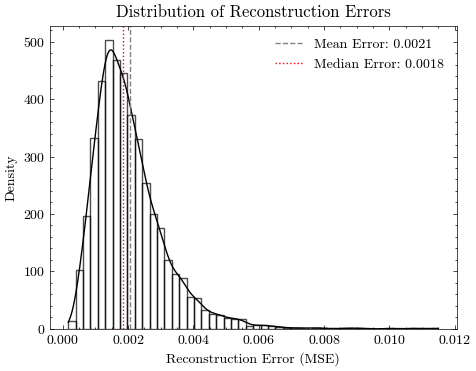

Mean Reconstruction Error: 0.0021
Median Reconstruction Error: 0.0018
Min Reconstruction Error: 0.0002
Max Reconstruction Error: 0.0115


In [215]:
report.analyze_reconstruction_error(model, X)

In [216]:
latents, reconstructed = model.predict(X)

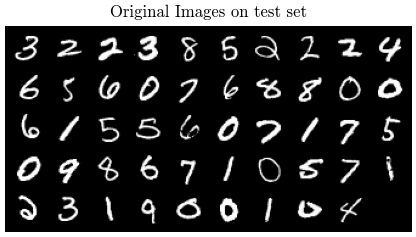

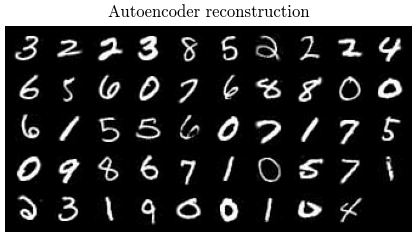

In [217]:
import torchvision.utils
# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed

def show_image(img):    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):       
    latents, reconstructed = model.predict(np.squeeze(images))    
    reconstructed = reconstructed.clip(0, 1)    
    reconstructed = torch.tensor(reconstructed)[0:50,None,:,:]
   
    np_imagegrid = torchvision.utils.make_grid(reconstructed, 10, 5).numpy()
    grid = np.squeeze(torchvision.utils.make_grid(reconstructed,10,5))
    show_image(grid)
    plt.title("Autoencoder reconstruction")
    plt.axis("off")
    plt.show()

images = torch.tensor(X_test[0:50,None,:,:])
plt.imshow(np.squeeze(images[0]))
plt.title("Original Images on test set")
# First visualise the original images
grid = np.squeeze(torchvision.utils.make_grid(images[1:50],10,5))
show_image(grid)
plt.axis("off")
plt.show()

# Reconstruct and visualise the images using the autoencoder
visualise_output(images[1:50], model)

In [218]:
report.analyze_latent_space(model, latents=latents)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 392
Total variance in latent space: 374.8533

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.4173
First 5 components              0.9998
Components for 95% variance     5
Variance Concentration Metric   0.9971

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.0481
Median absolute off-diagonal          0.0341
Max absolute off-diagonal             0.9999
Proportion of |Orthogonality| > 0.1   0.1179
Orthogonality Success Metric          0.9519

Orthogonality Interpretation:
Excellent orthogonality of feature


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0006
    - Max cosine similarity: 0.9996
    - Min cosine similarity: -0.9997
    


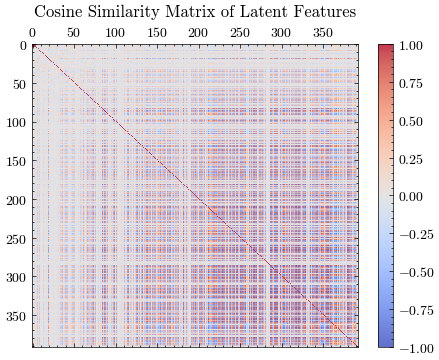

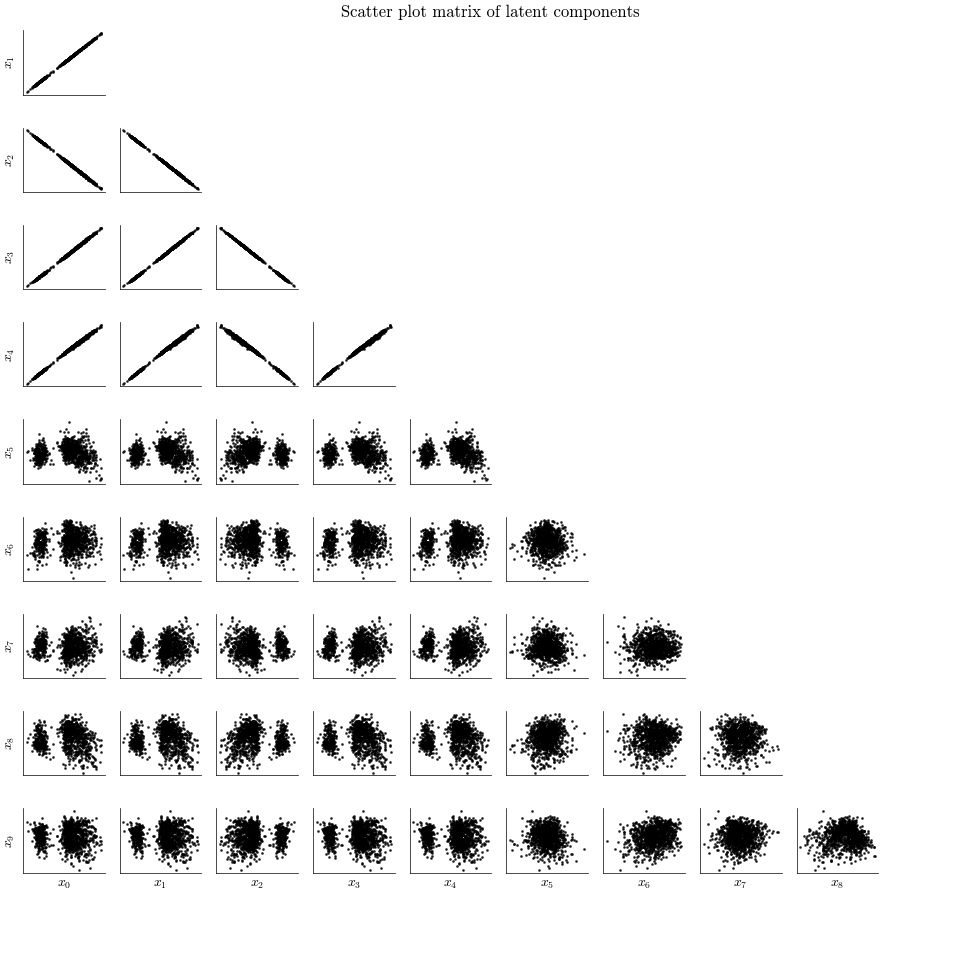

In [219]:
report.orthogonality_test_analysis(model, X)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 2.1018
    - Variance fit to exponential distribution (sum of squared differences):
     0.0569
    


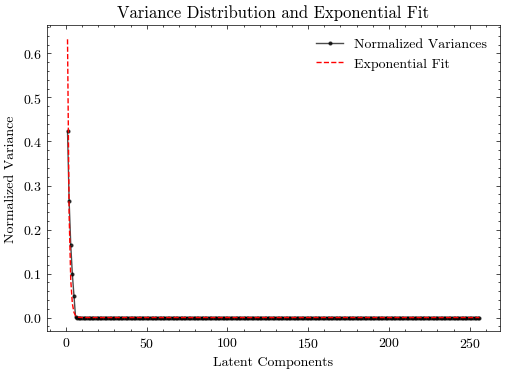

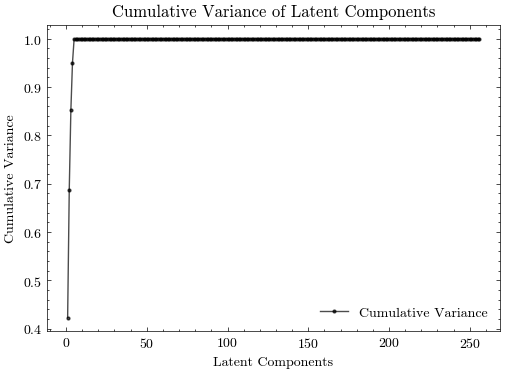

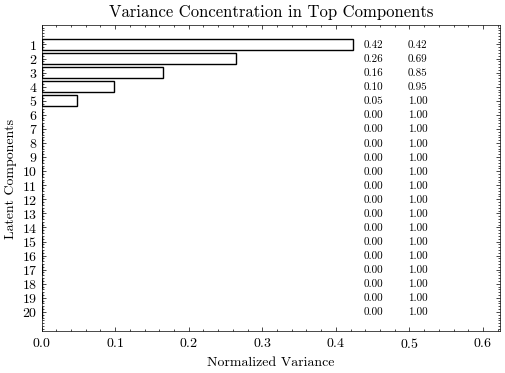

In [210]:
report.variance_test_analysis(model, X)

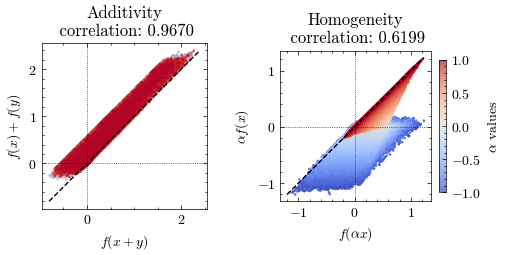

In [152]:
report.linearity_tests_analysis(model, X)

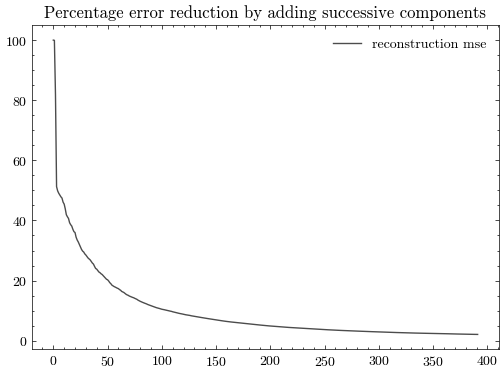

In [158]:
report.plot_cumsum_variance(model, X)

In [166]:
def plot2d_analysis(X, y, title, legend=True):
    fig = plt.figure(1, figsize=(5, 5))
    ax = fig.add_subplot(111)

    for label in range(10):
        ax.scatter(X[y == label, 0], X[y == label, 1], label=label)
        ax.set_xlabel("component: 0")
        ax.set_ylabel("component 1")
    if legend:
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()
    return fig, ax

In [167]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    _, _ = plot2d_analysis(Xpca, y_train, title="PCA transform", legend=True)
with o2:
    _, _ = plot2d_analysis(latents, y_train, title="POLCA-Net latent")
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

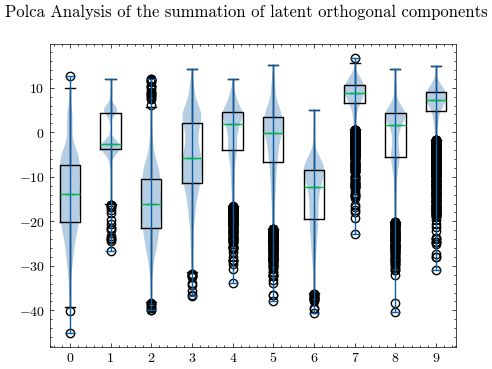

In [168]:
latents, reconstructed = model.predict(X)
vectors = []
labels = [str(i) for i in range(10)]
for c, label in enumerate(labels):
    vectors.append(np.sum(latents[y_train == c, :], axis=1))


plt.boxplot(vectors, tick_labels=labels)
plt.violinplot(vectors, showmeans=False, showmedians=True)
plt.suptitle("Polca Analysis of the summation of latent orthogonal components")
plt.show()

In [161]:
import seaborn as sns

o1 = widgets.Output()
o2 = widgets.Output()


with o1:
    scores = model.score(X)
    sns.displot(scores, kde=True)
    plt.title("Last component with clean data")
    plt.show()

with o2:
    scores = model.score(X * (np.random.random(size=X.shape) - 0.5) * 1)
    sns.displot(scores, kde=True)
    plt.title("Last componet with uniform noise in data")
    plt.show()


layout = widgets.Layout(grid_template_columns="repeat(2, 500px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 500px)'))

## Test Classification with two components on PCA vs POLCA Net

In [169]:
import pandas as pd
from scipy.stats import ttest_rel
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import minmax_scale, scale
from sklearn.svm import SVC

In [196]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.5, random_state=42)

In [197]:
X_train_pca = pca.transform(X_train.reshape(X_train.shape[0], -1))
X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))
X_train_pca.shape, X_test_pca.shape

((25000, 64), (25000, 64))

In [198]:
# Transform the data using POLCA-Net
# X_train_polca = model.predict(X_train,np.array([1, 1, 0, 0]))[0][:,:2]
X_train_polca = model.predict(X_train)[0][:, :pca.n_components]
# X_test_polca = model.predict(X_test, np.array([1, 1, 0, 0]))[0][:,:2]
X_test_polca = model.predict(X_test)[0][:, :pca.n_components]
X_train_polca.shape, X_test_polca.shape

((25000, 64), (25000, 64))

In [199]:
# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(solver='saga',n_jobs=30,max_iter=500),
    "Gaussian Naive Bayes": GaussianNB(),
    "Linear SVM": SVC(kernel="linear", probability=True),
    "Ridge Classifier": RidgeClassifier(),
    "Perceptron": Perceptron(n_jobs=30),
}

In [200]:
# Train and evaluate classifiers on both PCA and POLCA-Net transformed datasets
results = []
from tqdm.auto import tqdm
for name, clf in tqdm(classifiers.items()):
    # Train on PCA
    clf.fit(minmax_scale(X_train_pca), y_train)
    y_pred_pca = clf.predict(minmax_scale(X_test_pca))
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    report_pca = classification_report(y_test, y_pred_pca, output_dict=True)
    cm_pca = confusion_matrix(y_test, y_pred_pca)

    # Train on POLCA-Net
    clf.fit(minmax_scale(X_train_polca), y_train)
    y_pred_polca = clf.predict(minmax_scale(X_test_polca))
    accuracy_polca = accuracy_score(y_test, y_pred_polca)
    report_polca = classification_report(y_test, y_pred_polca, output_dict=True)
    cm_polca = confusion_matrix(y_test, y_pred_polca)

    # Append results
    results.append(
        {
            "Classifier": name,
            "Transformation": "PCA",
            "Accuracy": accuracy_pca,
            "Precision": report_pca["weighted avg"]["precision"],
            "Recall": report_pca["weighted avg"]["recall"],
            "F1-Score": report_pca["weighted avg"]["f1-score"],
            "Confusion Matrix": cm_pca,
        }
    )

    results.append(
        {
            "Classifier": name,
            "Transformation": "POLCA-Net",
            "Accuracy": accuracy_polca,
            "Precision": report_polca["weighted avg"]["precision"],
            "Recall": report_polca["weighted avg"]["recall"],
            "F1-Score": report_polca["weighted avg"]["f1-score"],
            "Confusion Matrix": cm_polca,
        }
    )

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Display the main metrics table
main_metrics_df = results_df.drop(columns=["Confusion Matrix"])
main_metrics_df["n_components"] = pca.n_components
main_metrics_df.T

  0%|          | 0/5 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9
Classifier,Logistic Regression,Logistic Regression,Gaussian Naive Bayes,Gaussian Naive Bayes,Linear SVM,Linear SVM,Ridge Classifier,Ridge Classifier,Perceptron,Perceptron
Transformation,PCA,POLCA-Net,PCA,POLCA-Net,PCA,POLCA-Net,PCA,POLCA-Net,PCA,POLCA-Net
Accuracy,0.89364,0.88752,0.857,0.79276,0.92048,0.91088,0.83424,0.81404,0.8474,0.786
Precision,0.895896,0.890376,0.864171,0.802037,0.921584,0.912666,0.840341,0.826415,0.868045,0.840849
Recall,0.89364,0.88752,0.857,0.79276,0.92048,0.91088,0.83424,0.81404,0.8474,0.786
F1-Score,0.893419,0.887513,0.857891,0.794189,0.920248,0.910712,0.832046,0.811004,0.848078,0.791889
n_components,64,64,64,64,64,64,64,64,64,64


In [201]:
# Statistical test: Paired t-test for accuracies
comparison_metrics = ["Accuracy","Precision","Recall","F1-Score"]
print(f"\nPaired t-test results:") 
for comparison_metric in comparison_metrics:

    print(f"{comparison_metric}:")
    pca_result = results_df[results_df["Transformation"] == "PCA"][comparison_metric]
    polca_result = results_df[results_df["Transformation"] == "POLCA-Net"][comparison_metric]    
    t_stat, p_value = ttest_rel(pca_result.values, polca_result.values)    
    print(f"\tt-statistic = {t_stat}, p-value = {p_value}, p-value threshold < {0.05}")    
    if p_value < 0.05:
        #print(f"There is a statistically significant difference between the PCA and POLCA-Net transformations")
        ans = "a"
    else:
        ans = "no"
    
    print(f"\tThere is {ans} statistically significant difference between the PCA and POLCA-Net transformations.")


Paired t-test results:
Accuracy:
	t-statistic = 2.548892335137145, p-value = 0.06337983604365495, p-value threshold < 0.05
	There is no statistically significant difference between the PCA and POLCA-Net transformations.
Precision:
	t-statistic = 2.2789281100159196, p-value = 0.08488688196262818, p-value threshold < 0.05
	There is no statistically significant difference between the PCA and POLCA-Net transformations.
Recall:
	t-statistic = 2.548892335137145, p-value = 0.06337983604365495, p-value threshold < 0.05
	There is no statistically significant difference between the PCA and POLCA-Net transformations.
F1-Score:
	t-statistic = 2.600345282465822, p-value = 0.060026316413075424, p-value threshold < 0.05
	There is no statistically significant difference between the PCA and POLCA-Net transformations.


In [ ]:
# Plotting the results
plt.figure(figsize=(10, 4))

# Plot PCA
plt.subplot(1, 2, 1)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap="viridis", edgecolor="k", s=50)
plt.title("PCA: Iris Test Set")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

# Plot POLCA-Net
plt.subplot(1, 2, 2)
plt.scatter(X_test_polca[:, 0], X_test_polca[:, 1], c=y_test, cmap="viridis", edgecolor="k", s=50)
plt.title("POLCA-Net: Iris Test Set")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.show()

# Plot Confusion Matrices for each classifier
fig, axes = plt.subplots(len(classifiers), 2, figsize=(10, 20))

for i, (name, clf) in enumerate(classifiers.items()):
    # PCA Confusion Matrix
    cm_pca = results_df[(results_df["Classifier"] == name) & (results_df["Transformation"] == "PCA")]["Confusion Matrix"].values[0]
    axes[i, 0].imshow(cm_pca, interpolation="nearest", cmap=plt.cm.Blues)
    axes[i, 0].set_title(f"{name} Confusion Matrix - PCA")
    axes[i, 0].set_xlabel("Predicted label")
    axes[i, 0].set_ylabel("True label")

    # POLCA-Net Confusion Matrix
    cm_polca = results_df[(results_df["Classifier"] == name) & (results_df["Transformation"] == "POLCA-Net")]["Confusion Matrix"].values[0]
    axes[i, 1].imshow(cm_polca, interpolation="nearest", cmap=plt.cm.Blues)
    axes[i, 1].set_title(f"{name} Confusion Matrix - POLCA-Net")
    axes[i, 1].set_xlabel("Predicted label")
    axes[i, 1].set_ylabel("True label")

plt.tight_layout()
plt.show()